Dataset Load + CNN Model + Training

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load Oxford-IIIT Pet dataset (cats and dogs)
raw_dataset = OxfordIIITPet(root="./data", download=True, transform=transform, target_types="category")

# Filter cats (label 0~4) and dogs (label 5~36), and convert to binary labels
filtered_data = []
for img, label in raw_dataset:
    if label <= 36:
        binary_label = 0 if label <= 4 else 1
        filtered_data.append((img, binary_label))

train_loader = DataLoader(filtered_data, batch_size=32, shuffle=True)

# Simple CNN for binary classification
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
loss_history = []
acc_history = []

for epoch in range(5):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)

    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

Epoch 1: Loss = 0.4096, Accuracy = 0.8636
Epoch 2: Loss = 0.3930, Accuracy = 0.8641
Epoch 3: Loss = 0.3859, Accuracy = 0.8641
Epoch 4: Loss = 0.3684, Accuracy = 0.8641
Epoch 5: Loss = 0.3564, Accuracy = 0.8660


Plot Loss and Accuracy

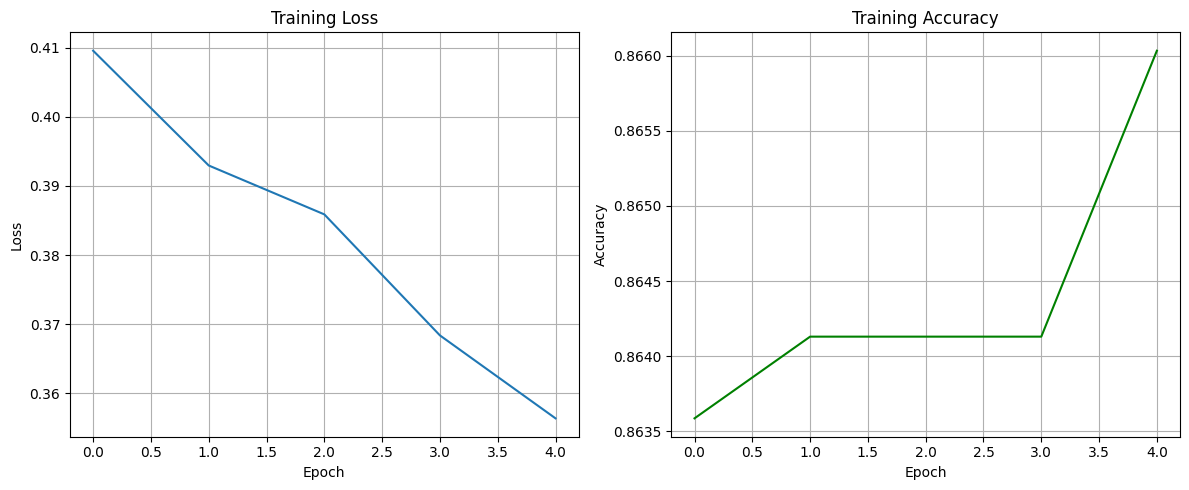

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

Confusion-Matrix

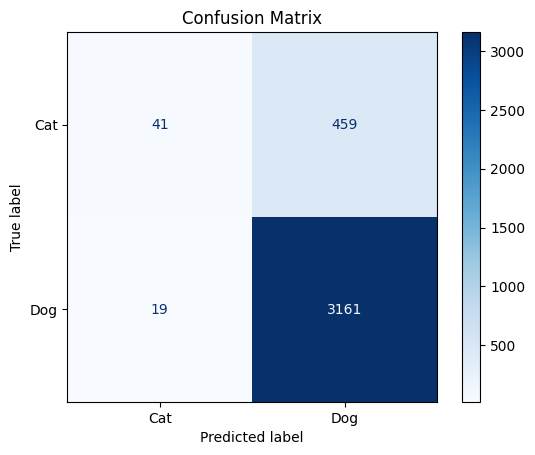

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

Show Correct and Incorrect Predictions

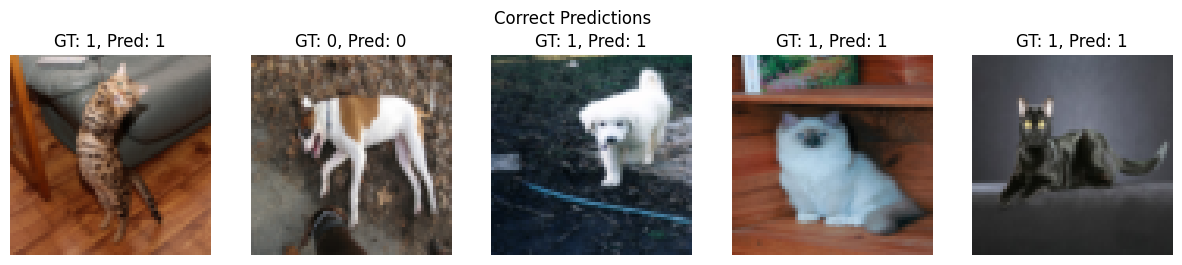

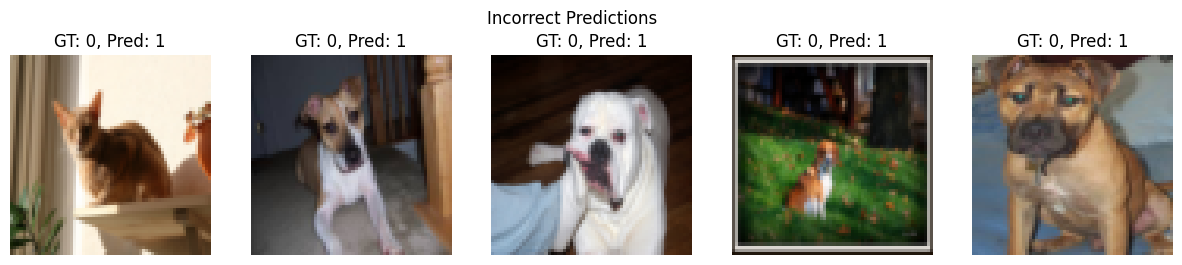

In [5]:
correct_samples = []
wrong_samples = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float().cpu()
        labels = labels.unsqueeze(1)

        for i in range(len(images)):
            img = images[i].cpu()
            gt = int(labels[i])
            pred = int(preds[i])

            if gt == pred and len(correct_samples) < 5:
                correct_samples.append((img, gt, pred))
            elif gt != pred and len(wrong_samples) < 5:
                wrong_samples.append((img, gt, pred))

        if len(correct_samples) == 5 and len(wrong_samples) == 5:
            break

def show_samples(samples, title):
    plt.figure(figsize=(15, 3))
    for i, (img, gt, pred) in enumerate(samples):
        plt.subplot(1, 5, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"GT: {gt}, Pred: {pred}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(correct_samples, "Correct Predictions")
show_samples(wrong_samples, "Incorrect Predictions")